# Gradient Boosting Model Training with Ablation Study
## GoBest Cab - Dangerous Driving Behaviour Detection

This notebook implements Gradient Boosting classifier for detecting dangerous driving behaviour with:
- MLflow experiment tracking
- Class imbalance handling
- Regularization techniques to prevent overfitting
- Comprehensive ablation study

In [3]:
# Import Required Libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (
    f1_score, precision_score, recall_score, accuracy_score,
    roc_auc_score, confusion_matrix, classification_report,
    ConfusionMatrixDisplay, roc_curve, precision_recall_curve
)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight

# MLflow
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

print("All libraries imported successfully!")

All libraries imported successfully!


## 1. MLflow Setup

In [4]:
# MLflow Configuration
# Set tracking URI to the MLflow server
mlflow.set_tracking_uri("http://localhost:5000")

# Define experiment naming convention: {model_name}_{dataset}_{reg/noreg}
EXPERIMENT_BASE_NAME = "GradientBoosting_balanced_smote"

print(f"MLflow Tracking URI: {mlflow.get_tracking_uri()}")

MLflow Tracking URI: http://localhost:5000


## 2. Load Data

In [5]:
# Load the main dataset
DATA_PATH = "../../Datasets/ca2_balanced_smote/balanced_smote.csv"
CLASS_WEIGHTS_PATH = "../../Datasets/ca2_balanced_smote/class_weights.json"

df = pd.read_csv(DATA_PATH)

# Load class weights from JSON
with open(CLASS_WEIGHTS_PATH, 'r') as f:
    class_weights_info = json.load(f)

print(f"Dataset shape: {df.shape}")
print(f"\nClass distribution:")
print(df['label'].value_counts())
print(f"\nClass weights info:")
print(json.dumps(class_weights_info, indent=2))

Dataset shape: (29988, 144)

Class distribution:
label
0    14994
1    14994
Name: count, dtype: int64

Class weights info:
{
  "class_0_weight": 0.665999733226624,
  "class_1_weight": 2.0060265166733626,
  "scale_pos_weight": 3.0120530333467253,
  "original_class_0": 14994,
  "original_class_1": 4978,
  "imbalance_ratio": 3.0120530333467257
}


In [6]:
# Prepare features and target
# IMPORTANT: Exclude bookingID and is_dangerous_trip - they are just references
columns_to_drop = ['bookingID', 'label']

# Check if is_dangerous_trip exists and drop it
if 'is_dangerous_trip' in df.columns:
    columns_to_drop.append('is_dangerous_trip')

# Also drop is_synthetic if it exists (it's a SMOTE indicator, not a feature)
if 'is_synthetic' in df.columns:
    columns_to_drop.append('is_synthetic')

X = df.drop(columns=columns_to_drop)
y = df['label']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns ({len(X.columns)}):")
print(X.columns.tolist()[:10], "... and", len(X.columns)-10, "more")

Features shape: (29988, 141)
Target shape: (29988,)

Feature columns (141):
['vehicle_key', 'trip_duration_sec', 'total_distance_km', 'avg_gps_accuracy', 'harsh_acceleration_count', 'harsh_braking_count', 'sharp_turn_count', 'speeding_event_count', 'phone_distraction_count', 'avg_acceleration_magnitude'] ... and 131 more


## 3. Data Preprocessing

In [7]:
# Check for missing values and handle them
print("Missing values per column:")
missing = X.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
    # Fill missing values with median (robust to outliers)
    X = X.fillna(X.median())
    print("\nMissing values filled with median.")
else:
    print("No missing values found.")

# Check for infinite values
inf_count = np.isinf(X.select_dtypes(include=[np.number])).sum().sum()
print(f"\nInfinite values count: {inf_count}")
if inf_count > 0:
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.median())
    print("Infinite values replaced with median.")

Missing values per column:
No missing values found.

Infinite values count: 0


In [8]:
# Train-test split with stratification to preserve class ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining class distribution:")
print(y_train.value_counts(normalize=True))
print(f"\nTest class distribution:")
print(y_test.value_counts(normalize=True))

Training set: 23990 samples
Test set: 5998 samples

Training class distribution:
label
1    0.5
0    0.5
Name: proportion, dtype: float64

Test class distribution:
label
0    0.5
1    0.5
Name: proportion, dtype: float64


In [9]:
# Feature scaling using RobustScaler (less sensitive to outliers)
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), 
    columns=X_train.columns, 
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test), 
    columns=X_test.columns, 
    index=X_test.index
)

print("Feature scaling completed using RobustScaler.")

Feature scaling completed using RobustScaler.


## 4. Class Imbalance Handling

In [10]:
# For Gradient Boosting, we use sample_weight instead of class_weight
# Compute sample weights based on class distribution
class_weight_dict = {
    0: class_weights_info.get('class_0_weight', 1.0),
    1: class_weights_info.get('class_1_weight', 3.0)
}

# Compute sample weights for training
sample_weights_train = compute_sample_weight('balanced', y_train)

print(f"Class weight dictionary: {class_weight_dict}")
print(f"Sample weights computed for {len(sample_weights_train)} samples")
print(f"Sample weight range: [{sample_weights_train.min():.4f}, {sample_weights_train.max():.4f}]")

Class weight dictionary: {0: 0.665999733226624, 1: 2.0060265166733626}
Sample weights computed for 23990 samples
Sample weight range: [1.0000, 1.0000]


## 5. Helper Functions

In [11]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    """
    Comprehensive model evaluation with all required metrics.
    """
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metrics = {
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'train_f1': f1_score(y_train, y_train_pred),
        'test_f1': f1_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'roc_auc': roc_auc_score(y_test, y_test_proba),
    }
    
    # Detect overfitting
    overfit_gap = metrics['train_f1'] - metrics['test_f1']
    metrics['overfit_gap'] = overfit_gap
    metrics['is_overfitting'] = overfit_gap > 0.05  # 5% gap threshold
    
    # Print results
    print(f"\n{'='*60}")
    print(f"{model_name} Evaluation Results")
    print(f"{'='*60}")
    print(f"\nAccuracy  - Train: {metrics['train_accuracy']:.4f} | Test: {metrics['test_accuracy']:.4f}")
    print(f"F1 Score  - Train: {metrics['train_f1']:.4f} | Test: {metrics['test_f1']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"ROC-AUC:   {metrics['roc_auc']:.4f}")
    print(f"\nOverfit Gap (Train F1 - Test F1): {overfit_gap:.4f}")
    if metrics['is_overfitting']:
        print("⚠️  WARNING: Model shows signs of overfitting!")
    else:
        print("✅ Model generalization looks good.")
    
    return metrics, y_test_pred, y_test_proba


def plot_confusion_matrix(y_test, y_pred, model_name="Model"):
    """
    Plot confusion matrix.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Safe (0)', 'Dangerous (1)'])
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.tight_layout()
    return fig


def plot_roc_curve(y_test, y_proba, model_name="Model"):
    """
    Plot ROC curve.
    """
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{model_name} - ROC Curve')
    ax.legend(loc='lower right')
    plt.tight_layout()
    return fig


def plot_feature_importance(model, feature_names, top_n=20, model_name="Model"):
    """
    Plot top N feature importances.
    """
    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1][:top_n]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.barh(range(top_n), importance[indices][::-1], align='center')
    ax.set_yticks(range(top_n))
    ax.set_yticklabels([feature_names[i] for i in indices][::-1])
    ax.set_xlabel('Feature Importance')
    ax.set_title(f'{model_name} - Top {top_n} Feature Importances')
    plt.tight_layout()
    return fig


def plot_learning_curve(model, model_name="Model"):
    """
    Plot training deviance over iterations.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot training deviance
    train_scores = model.train_score_
    ax.plot(range(1, len(train_scores) + 1), train_scores, 'b-', label='Training Deviance')
    
    ax.set_xlabel('Boosting Iterations')
    ax.set_ylabel('Deviance')
    ax.set_title(f'{model_name} - Learning Curve')
    ax.legend(loc='upper right')
    plt.tight_layout()
    return fig

## 6. Cross-Validation Setup

In [12]:
# Stratified K-Fold Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def perform_cross_validation(model, X, y, cv=cv):
    """
    Perform cross-validation and return scores.
    """
    scoring = ['f1', 'precision', 'recall', 'roc_auc', 'accuracy']
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=True)
    
    print("\nCross-Validation Results (5-fold):")
    print("-" * 50)
    for metric in scoring:
        train_scores = cv_results[f'train_{metric}']
        test_scores = cv_results[f'test_{metric}']
        print(f"{metric.upper():12} - Train: {train_scores.mean():.4f} (+/- {train_scores.std()*2:.4f}) | "
              f"Test: {test_scores.mean():.4f} (+/- {test_scores.std()*2:.4f})")
    
    return cv_results

---
## 7. Model Training WITHOUT Regularization
### Baseline Gradient Boosting Model (High Complexity, No Regularization)

In [13]:
# Set experiment for no regularization
mlflow.set_experiment(f"{EXPERIMENT_BASE_NAME}_noreg")

print(f"Experiment: {EXPERIMENT_BASE_NAME}_noreg")

Experiment: GradientBoosting_balanced_smote_noreg


In [14]:
# Gradient Boosting WITHOUT Regularization (baseline - likely to overfit)
gb_noreg = GradientBoostingClassifier(
    n_estimators=100,  # Reduced for faster training
    max_depth=10,  # Deep trees - prone to overfitting
    learning_rate=0.1,
    min_samples_split=2,  # Low value - prone to overfitting
    min_samples_leaf=1,  # Low value - prone to overfitting
    max_features=None,  # Use all features
    subsample=1.0,  # Use all samples
    max_leaf_nodes=200,  # Limited for faster training (still allows overfitting)
    random_state=42,
    validation_fraction=0.1,
    n_iter_no_change=None  # No early stopping
)

print("Gradient Boosting Model (No Regularization) Configuration:")
print(gb_noreg.get_params())

Gradient Boosting Model (No Regularization) Configuration:
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': 200, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


Training Gradient Boosting without regularization...

Gradient Boosting (No Regularization) Evaluation Results

Accuracy  - Train: 0.9999 | Test: 0.8581
F1 Score  - Train: 0.9999 | Test: 0.8512
Precision: 0.8949
Recall:    0.8116
ROC-AUC:   0.9278

Overfit Gap (Train F1 - Test F1): 0.1487
⚠️  WARNING: Model shows signs of overfitting!


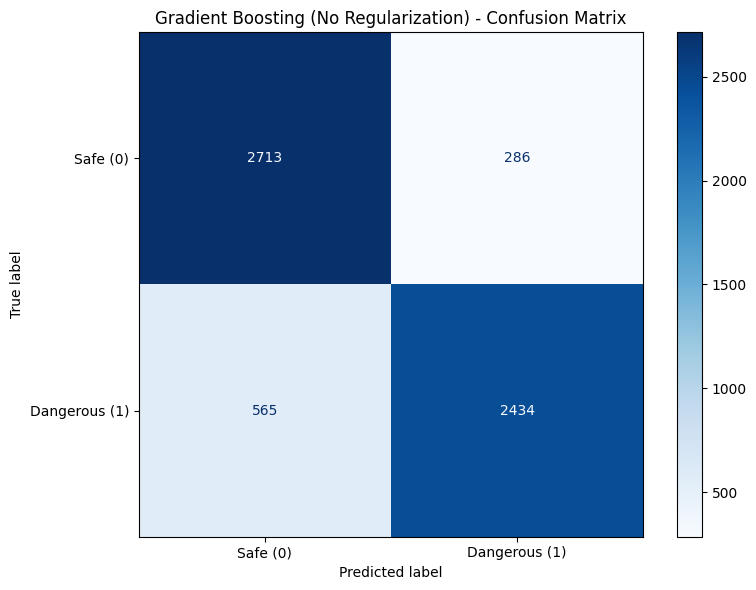

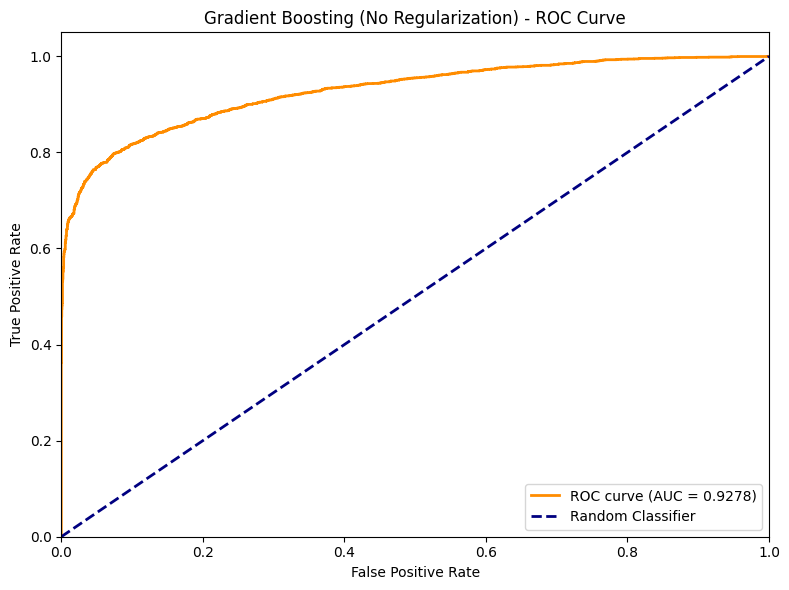

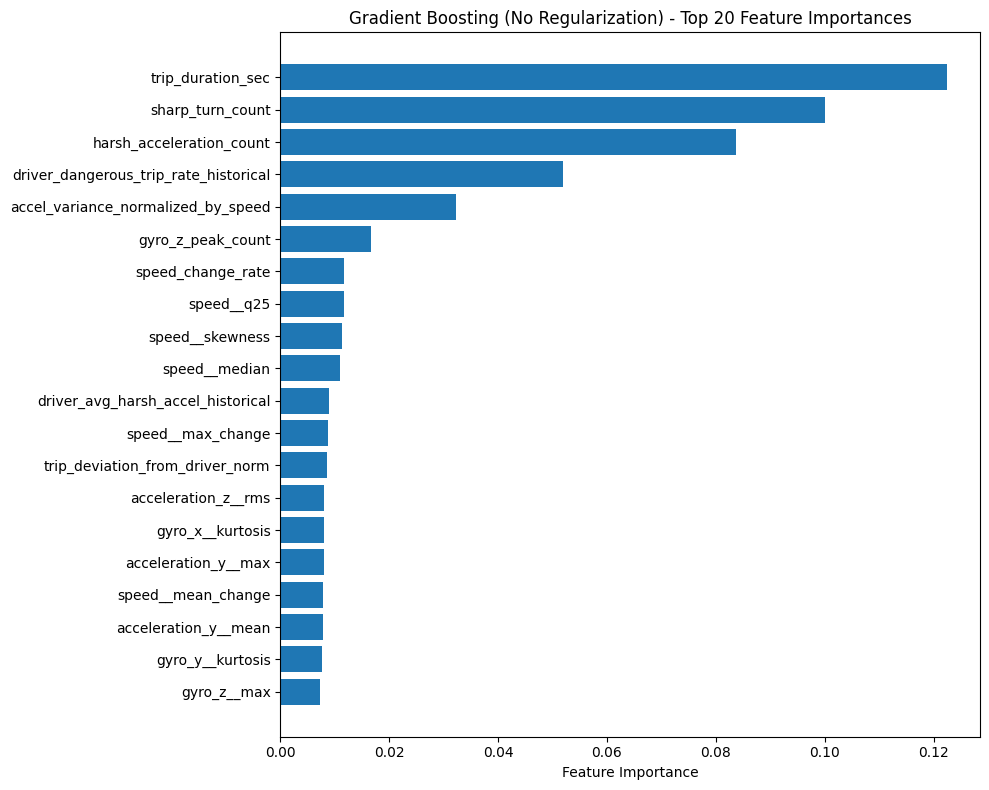

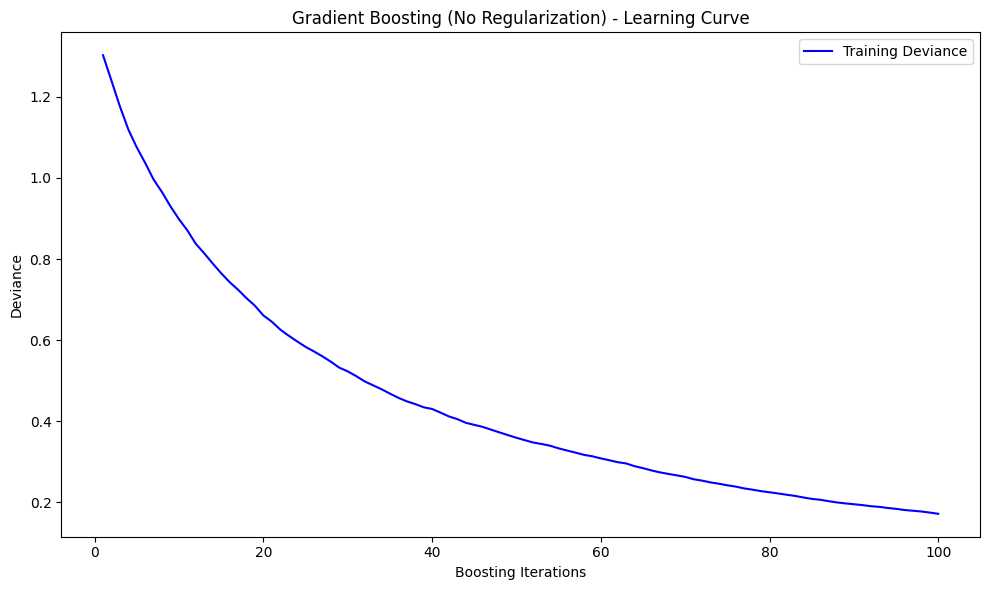

2026/01/31 16:50:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✅ Run logged to MLflow with ID: 86aa9c472d894497a60de6d14fc360eb
🏃 View run GradientBoosting_NoReg_Baseline at: http://localhost:5000/#/experiments/3/runs/86aa9c472d894497a60de6d14fc360eb
🧪 View experiment at: http://localhost:5000/#/experiments/3


In [15]:
# Train the model without regularization
with mlflow.start_run(run_name="GradientBoosting_NoReg_Baseline"):
    # Log parameters
    mlflow.log_params(gb_noreg.get_params())
    mlflow.log_param("regularization", "none")
    mlflow.log_param("dataset", "balanced_smote")
    mlflow.log_param("n_features", X_train_scaled.shape[1])
    mlflow.log_param("n_train_samples", X_train_scaled.shape[0])
    
    # Train model with sample weights
    print("Training Gradient Boosting without regularization...")
    gb_noreg.fit(X_train_scaled, y_train, sample_weight=sample_weights_train)
    
    # Evaluate
    metrics_noreg, y_pred_noreg, y_proba_noreg = evaluate_model(
        gb_noreg, X_train_scaled, X_test_scaled, y_train, y_test, 
        model_name="Gradient Boosting (No Regularization)"
    )
    
    # Log metrics
    mlflow.log_metrics({
        'train_accuracy': metrics_noreg['train_accuracy'],
        'test_accuracy': metrics_noreg['test_accuracy'],
        'train_f1': metrics_noreg['train_f1'],
        'test_f1': metrics_noreg['test_f1'],
        'precision': metrics_noreg['precision'],
        'recall': metrics_noreg['recall'],
        'roc_auc': metrics_noreg['roc_auc'],
        'overfit_gap': metrics_noreg['overfit_gap']
    })
    
    # Plot and log confusion matrix
    fig_cm = plot_confusion_matrix(y_test, y_pred_noreg, "Gradient Boosting (No Regularization)")
    mlflow.log_figure(fig_cm, "confusion_matrix_noreg.png")
    plt.show()
    
    # Plot and log ROC curve
    fig_roc = plot_roc_curve(y_test, y_proba_noreg, "Gradient Boosting (No Regularization)")
    mlflow.log_figure(fig_roc, "roc_curve_noreg.png")
    plt.show()
    
    # Plot and log feature importance
    fig_fi = plot_feature_importance(gb_noreg, X_train_scaled.columns.tolist(), top_n=20, 
                                     model_name="Gradient Boosting (No Regularization)")
    mlflow.log_figure(fig_fi, "feature_importance_noreg.png")
    plt.show()
    
    # Plot learning curve
    fig_lc = plot_learning_curve(gb_noreg, "Gradient Boosting (No Regularization)")
    mlflow.log_figure(fig_lc, "learning_curve_noreg.png")
    plt.show()
    
    # Log model
    signature = infer_signature(X_train_scaled, y_train)
    mlflow.sklearn.log_model(gb_noreg, "model", signature=signature)
    
    print(f"\n✅ Run logged to MLflow with ID: {mlflow.active_run().info.run_id}")

In [16]:
# Cross-validation for no-reg model
print("\n" + "="*60)
print("Cross-Validation for Gradient Boosting (No Regularization)")
print("="*60)
cv_results_noreg = perform_cross_validation(gb_noreg, X_train_scaled, y_train)


Cross-Validation for Gradient Boosting (No Regularization)

Cross-Validation Results (5-fold):
--------------------------------------------------
F1           - Train: 1.0000 (+/- 0.0000) | Test: 0.8418 (+/- 0.0074)
PRECISION    - Train: 1.0000 (+/- 0.0000) | Test: 0.8878 (+/- 0.0153)
RECALL       - Train: 1.0000 (+/- 0.0000) | Test: 0.8004 (+/- 0.0034)
ROC_AUC      - Train: 1.0000 (+/- 0.0000) | Test: 0.9225 (+/- 0.0055)
ACCURACY     - Train: 1.0000 (+/- 0.0000) | Test: 0.8496 (+/- 0.0081)


In [17]:
# Classification Report
print("\nClassification Report (No Regularization):")
print(classification_report(y_test, y_pred_noreg, target_names=['Safe (0)', 'Dangerous (1)']))


Classification Report (No Regularization):
               precision    recall  f1-score   support

     Safe (0)       0.83      0.90      0.86      2999
Dangerous (1)       0.89      0.81      0.85      2999

     accuracy                           0.86      5998
    macro avg       0.86      0.86      0.86      5998
 weighted avg       0.86      0.86      0.86      5998



---
## 8. Model Training WITH Regularization
### Gradient Boosting with Regularization to Combat Overfitting

In [18]:
# Set experiment for regularized model
mlflow.set_experiment(f"{EXPERIMENT_BASE_NAME}_reg")

print(f"Experiment: {EXPERIMENT_BASE_NAME}_reg")

Experiment: GradientBoosting_balanced_smote_reg


In [19]:
# Gradient Boosting WITH Regularization
gb_reg = GradientBoostingClassifier(
    n_estimators=300,
    max_depth=5,  # Reduced depth
    learning_rate=0.05,  # Lower learning rate
    min_samples_split=20,  # Higher value for regularization
    min_samples_leaf=10,  # Higher value
    max_features='sqrt',  # Feature subsampling
    subsample=0.8,  # Stochastic gradient boosting
    max_leaf_nodes=50,  # Limit leaf nodes
    min_impurity_decrease=0.001,  # Minimum impurity decrease
    random_state=42,
    validation_fraction=0.1,
    n_iter_no_change=20  # Early stopping
)

print("Gradient Boosting Model (With Regularization) Configuration:")
print("\nRegularization techniques applied:")
print("- Reduced max_depth: 10 -> 5")
print("- Lower learning_rate: 0.1 -> 0.05")
print("- Increased min_samples_split: 2 -> 20")
print("- Increased min_samples_leaf: 1 -> 10")
print("- Feature subsampling: None -> sqrt")
print("- Stochastic subsampling: 1.0 -> 0.8")
print("- Limited max_leaf_nodes: None -> 50")
print("- Early stopping with n_iter_no_change: 20")

Gradient Boosting Model (With Regularization) Configuration:

Regularization techniques applied:
- Reduced max_depth: 10 -> 5
- Lower learning_rate: 0.1 -> 0.05
- Increased min_samples_split: 2 -> 20
- Increased min_samples_leaf: 1 -> 10
- Feature subsampling: None -> sqrt
- Stochastic subsampling: 1.0 -> 0.8
- Limited max_leaf_nodes: None -> 50
- Early stopping with n_iter_no_change: 20


Training Gradient Boosting with regularization...

Actual estimators used: 300

Gradient Boosting (Regularized) Evaluation Results

Accuracy  - Train: 0.8786 | Test: 0.8178
F1 Score  - Train: 0.8737 | Test: 0.8098
Precision: 0.8468
Recall:    0.7759
ROC-AUC:   0.8974

Overfit Gap (Train F1 - Test F1): 0.0639
⚠️  WARNING: Model shows signs of overfitting!


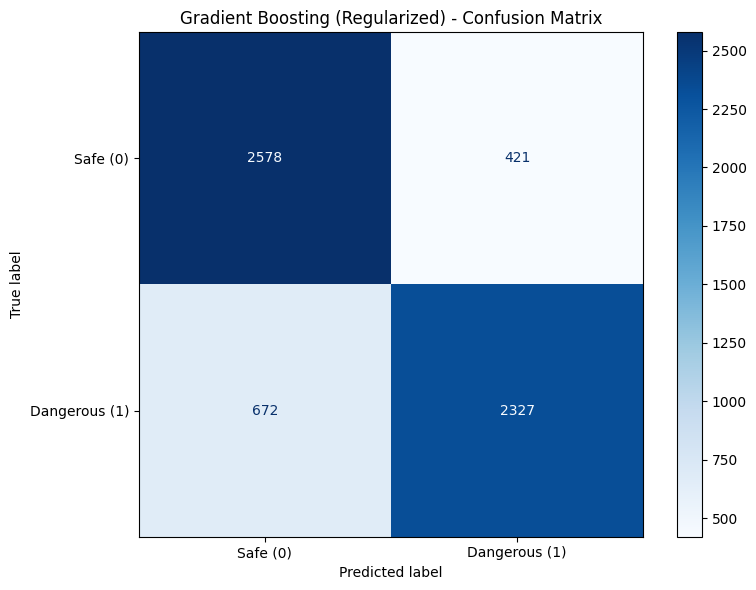

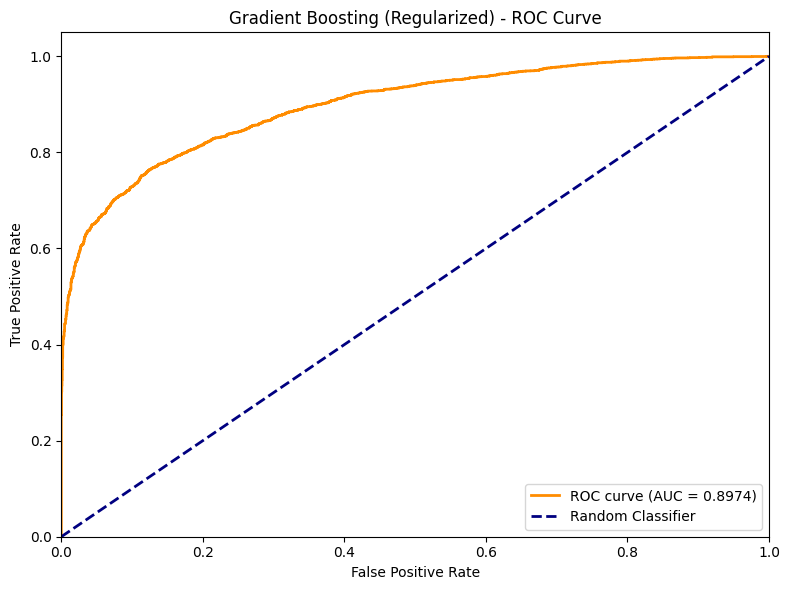

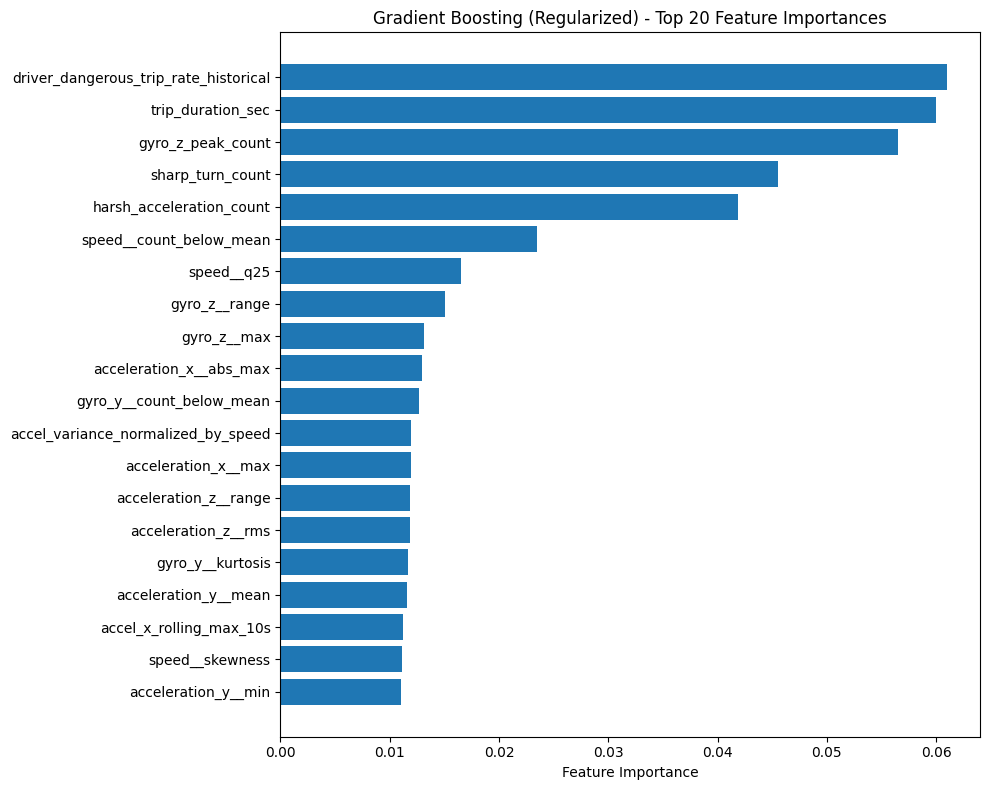

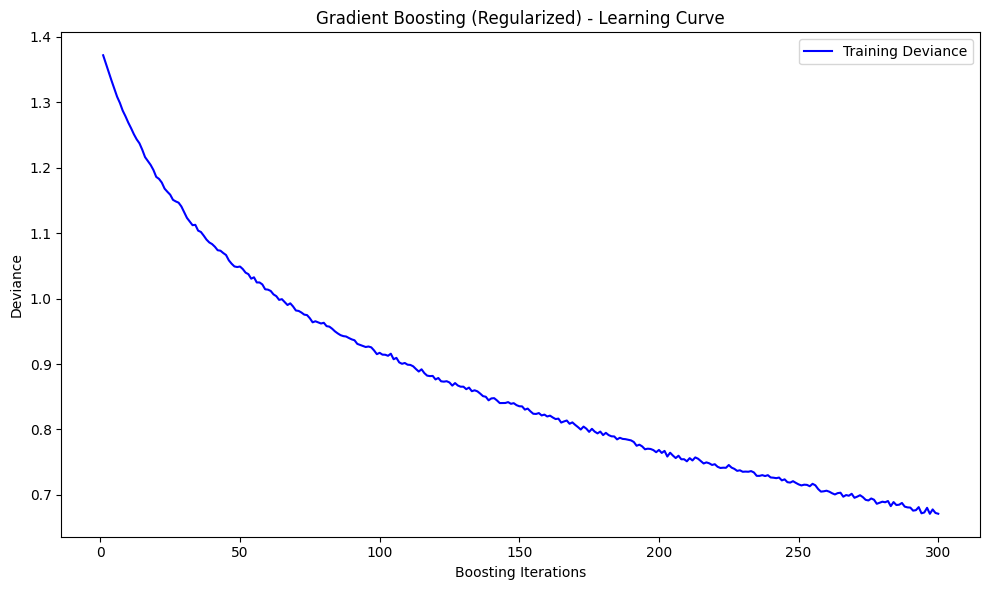

2026/01/31 17:00:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✅ Run logged to MLflow with ID: 0a442aa1f2034f12b7e1ec2c13602ff3
🏃 View run GradientBoosting_Regularized at: http://localhost:5000/#/experiments/4/runs/0a442aa1f2034f12b7e1ec2c13602ff3
🧪 View experiment at: http://localhost:5000/#/experiments/4


In [20]:
# Train the model with regularization
with mlflow.start_run(run_name="GradientBoosting_Regularized"):
    # Log parameters
    mlflow.log_params(gb_reg.get_params())
    mlflow.log_param("regularization", "shrinkage_subsampling_early_stopping")
    mlflow.log_param("dataset", "balanced_smote")
    mlflow.log_param("n_features", X_train_scaled.shape[1])
    mlflow.log_param("n_train_samples", X_train_scaled.shape[0])
    
    # Train model with sample weights
    print("Training Gradient Boosting with regularization...")
    gb_reg.fit(X_train_scaled, y_train, sample_weight=sample_weights_train)
    
    # Log actual number of estimators (may be less due to early stopping)
    print(f"\nActual estimators used: {gb_reg.n_estimators_}")
    
    # Evaluate
    metrics_reg, y_pred_reg, y_proba_reg = evaluate_model(
        gb_reg, X_train_scaled, X_test_scaled, y_train, y_test, 
        model_name="Gradient Boosting (Regularized)"
    )
    
    # Log metrics
    mlflow.log_metrics({
        'train_accuracy': metrics_reg['train_accuracy'],
        'test_accuracy': metrics_reg['test_accuracy'],
        'train_f1': metrics_reg['train_f1'],
        'test_f1': metrics_reg['test_f1'],
        'precision': metrics_reg['precision'],
        'recall': metrics_reg['recall'],
        'roc_auc': metrics_reg['roc_auc'],
        'overfit_gap': metrics_reg['overfit_gap'],
        'actual_n_estimators': gb_reg.n_estimators_
    })
    
    # Plot and log confusion matrix
    fig_cm = plot_confusion_matrix(y_test, y_pred_reg, "Gradient Boosting (Regularized)")
    mlflow.log_figure(fig_cm, "confusion_matrix_reg.png")
    plt.show()
    
    # Plot and log ROC curve
    fig_roc = plot_roc_curve(y_test, y_proba_reg, "Gradient Boosting (Regularized)")
    mlflow.log_figure(fig_roc, "roc_curve_reg.png")
    plt.show()
    
    # Plot and log feature importance
    fig_fi = plot_feature_importance(gb_reg, X_train_scaled.columns.tolist(), top_n=20, 
                                     model_name="Gradient Boosting (Regularized)")
    mlflow.log_figure(fig_fi, "feature_importance_reg.png")
    plt.show()
    
    # Plot learning curve
    fig_lc = plot_learning_curve(gb_reg, "Gradient Boosting (Regularized)")
    mlflow.log_figure(fig_lc, "learning_curve_reg.png")
    plt.show()
    
    # Log model
    signature = infer_signature(X_train_scaled, y_train)
    mlflow.sklearn.log_model(gb_reg, "model", signature=signature)
    
    print(f"\n✅ Run logged to MLflow with ID: {mlflow.active_run().info.run_id}")

In [21]:
# Cross-validation for regularized model
print("\n" + "="*60)
print("Cross-Validation for Gradient Boosting (Regularized)")
print("="*60)
cv_results_reg = perform_cross_validation(gb_reg, X_train_scaled, y_train)


Cross-Validation for Gradient Boosting (Regularized)

Cross-Validation Results (5-fold):
--------------------------------------------------
F1           - Train: 0.8819 (+/- 0.0041) | Test: 0.8053 (+/- 0.0117)
PRECISION    - Train: 0.9166 (+/- 0.0027) | Test: 0.8385 (+/- 0.0149)
RECALL       - Train: 0.8498 (+/- 0.0088) | Test: 0.7747 (+/- 0.0115)
ROC_AUC      - Train: 0.9573 (+/- 0.0014) | Test: 0.8929 (+/- 0.0084)
ACCURACY     - Train: 0.8862 (+/- 0.0034) | Test: 0.8127 (+/- 0.0116)


In [22]:
# Classification Report
print("\nClassification Report (Regularized):")
print(classification_report(y_test, y_pred_reg, target_names=['Safe (0)', 'Dangerous (1)']))


Classification Report (Regularized):
               precision    recall  f1-score   support

     Safe (0)       0.79      0.86      0.83      2999
Dangerous (1)       0.85      0.78      0.81      2999

     accuracy                           0.82      5998
    macro avg       0.82      0.82      0.82      5998
 weighted avg       0.82      0.82      0.82      5998



---
## 9. Model Improvement (If F1 Score is Low)
### Enhanced Gradient Boosting with Additional Preprocessing and Tuning

In [23]:
# Check if F1 score needs improvement (target: 0.87-0.90)
# First, determine which model performs better: regularized or non-regularized
f1_target_min = 0.87

print("="*60)
print("MODEL COMPARISON: Regularized vs Non-Regularized")
print("="*60)
print(f"No Regularization - Test F1: {metrics_noreg['test_f1']:.4f} | Overfit Gap: {metrics_noreg['overfit_gap']:.4f}")
print(f"Regularized       - Test F1: {metrics_reg['test_f1']:.4f} | Overfit Gap: {metrics_reg['overfit_gap']:.4f}")

# Select the better model based on Test F1 score
if metrics_noreg['test_f1'] > metrics_reg['test_f1']:
    best_base_model = 'noreg'
    best_base_f1 = metrics_noreg['test_f1']
    best_base_metrics = metrics_noreg
    print(f"\n🏆 Better Model: No Regularization (Test F1: {best_base_f1:.4f})")
else:
    best_base_model = 'reg'
    best_base_f1 = metrics_reg['test_f1']
    best_base_metrics = metrics_reg
    print(f"\n🏆 Better Model: Regularized (Test F1: {best_base_f1:.4f})")

print(f"\nTarget F1 Score Range: {f1_target_min} - 0.90")

if best_base_f1 < f1_target_min:
    print(f"\n⚠️  Best model F1 ({best_base_f1:.4f}) is below target. Applying improvements to {best_base_model} model...")
    NEEDS_IMPROVEMENT = True
else:
    print(f"\n✅ Best model F1 meets target. Model improvement optional.")
    NEEDS_IMPROVEMENT = False

MODEL COMPARISON: Regularized vs Non-Regularized
No Regularization - Test F1: 0.8512 | Overfit Gap: 0.1487
Regularized       - Test F1: 0.8098 | Overfit Gap: 0.0639

🏆 Better Model: No Regularization (Test F1: 0.8512)

Target F1 Score Range: 0.87 - 0.90

⚠️  Best model F1 (0.8512) is below target. Applying improvements to noreg model...


In [24]:
# Enhanced preprocessing: Remove low-variance features
from sklearn.feature_selection import VarianceThreshold

# Remove features with very low variance
variance_selector = VarianceThreshold(threshold=0.01)
X_train_var = variance_selector.fit_transform(X_train_scaled)
X_test_var = variance_selector.transform(X_test_scaled)

# Get selected feature names
selected_features = X_train_scaled.columns[variance_selector.get_support()].tolist()

print(f"Original features: {X_train_scaled.shape[1]}")
print(f"Features after variance threshold: {X_train_var.shape[1]}")
print(f"Features removed: {X_train_scaled.shape[1] - X_train_var.shape[1]}")

Original features: 141
Features after variance threshold: 141
Features removed: 0


In [25]:
# Improved Gradient Boosting with optimized hyperparameters
gb_improved = GradientBoostingClassifier(
    n_estimators=500,  # More iterations with lower learning rate
    max_depth=4,  # Shallower trees
    learning_rate=0.03,  # Even lower learning rate
    min_samples_split=25,  # More conservative
    min_samples_leaf=15,  # Larger leaves
    max_features='sqrt',
    subsample=0.75,  # More aggressive subsampling
    max_leaf_nodes=40,
    min_impurity_decrease=0.002,
    random_state=42,
    validation_fraction=0.15,
    n_iter_no_change=25,
    tol=1e-4
)

print("Improved Gradient Boosting Configuration:")
print("- Increased n_estimators: 300 -> 500")
print("- Reduced learning_rate: 0.05 -> 0.03")
print("- Shallower max_depth: 5 -> 4")
print("- More conservative min_samples: 20 -> 25")
print("- More aggressive subsampling: 0.8 -> 0.75")
print("- Increased validation_fraction: 0.1 -> 0.15")

Improved Gradient Boosting Configuration:
- Increased n_estimators: 300 -> 500
- Reduced learning_rate: 0.05 -> 0.03
- Shallower max_depth: 5 -> 4
- More conservative min_samples: 20 -> 25
- More aggressive subsampling: 0.8 -> 0.75
- Increased validation_fraction: 0.1 -> 0.15


Training improved Gradient Boosting...

Actual estimators used: 500

Gradient Boosting (Improved) Evaluation Results

Accuracy  - Train: 0.8411 | Test: 0.8058
F1 Score  - Train: 0.8346 | Test: 0.7976
Precision: 0.8327
Recall:    0.7653
ROC-AUC:   0.8865

Overfit Gap (Train F1 - Test F1): 0.0371
✅ Model generalization looks good.


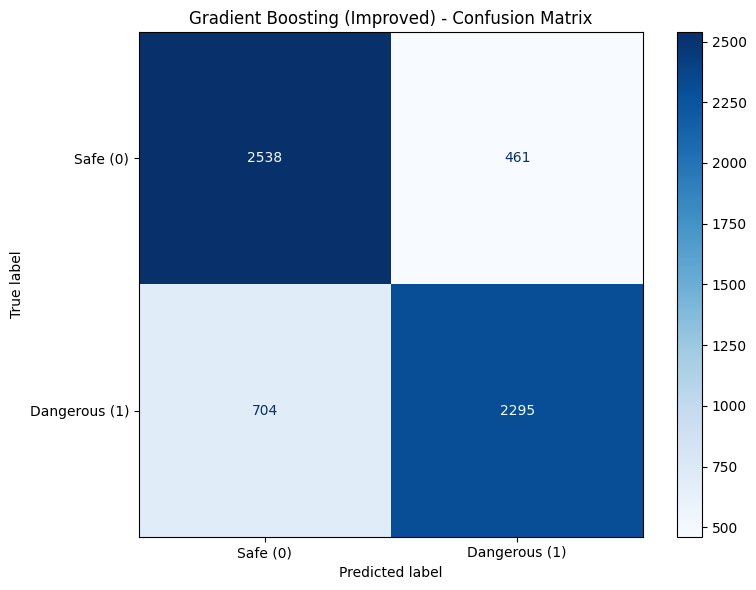

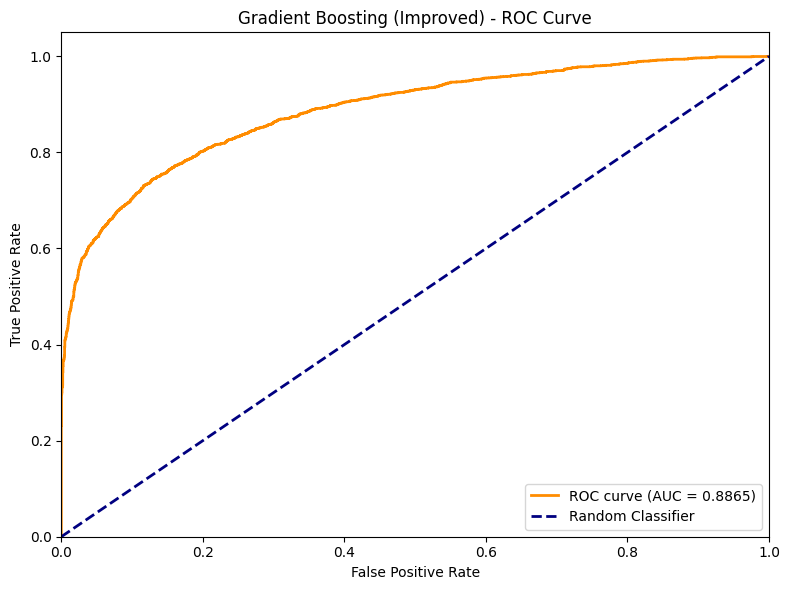

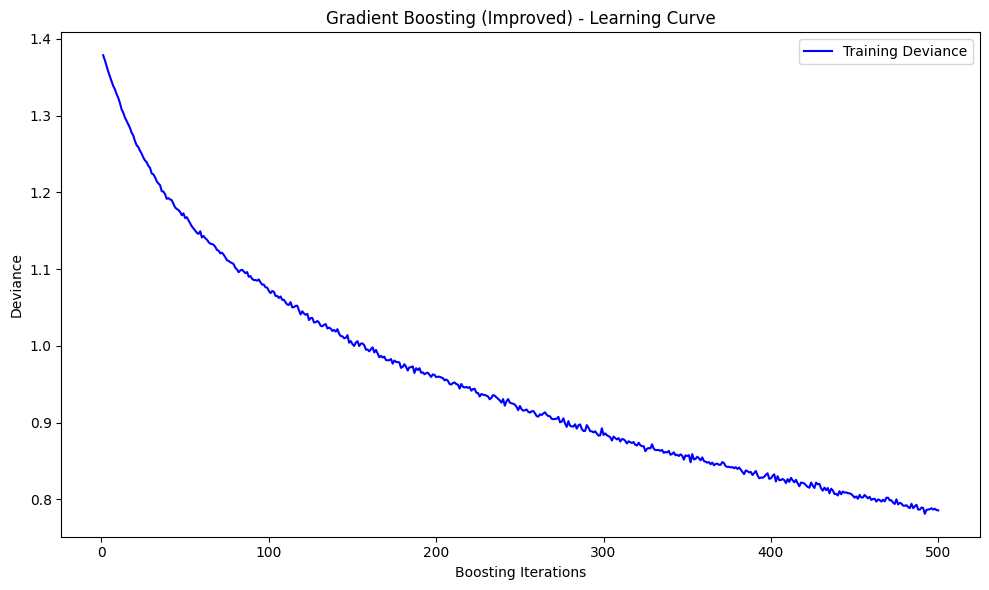

2026/01/31 17:02:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✅ Run logged to MLflow with ID: 8960dfa51132441f957604bd23d6adcc
🏃 View run GradientBoosting_Improved at: http://localhost:5000/#/experiments/4/runs/8960dfa51132441f957604bd23d6adcc
🧪 View experiment at: http://localhost:5000/#/experiments/4


In [26]:
# Train improved model
with mlflow.start_run(run_name="GradientBoosting_Improved"):
    # Log parameters
    mlflow.log_params(gb_improved.get_params())
    mlflow.log_param("regularization", "enhanced")
    mlflow.log_param("dataset", "balanced_smote")
    mlflow.log_param("preprocessing", "variance_threshold")
    mlflow.log_param("n_features", X_train_var.shape[1])
    mlflow.log_param("n_train_samples", X_train_var.shape[0])
    
    # Compute sample weights for the reduced feature set
    sample_weights_train_var = compute_sample_weight('balanced', y_train)
    
    # Train model
    print("Training improved Gradient Boosting...")
    gb_improved.fit(X_train_var, y_train, sample_weight=sample_weights_train_var)
    
    print(f"\nActual estimators used: {gb_improved.n_estimators_}")
    
    # Evaluate
    metrics_improved, y_pred_improved, y_proba_improved = evaluate_model(
        gb_improved, X_train_var, X_test_var, y_train, y_test, 
        model_name="Gradient Boosting (Improved)"
    )
    
    # Log metrics
    mlflow.log_metrics({
        'train_accuracy': metrics_improved['train_accuracy'],
        'test_accuracy': metrics_improved['test_accuracy'],
        'train_f1': metrics_improved['train_f1'],
        'test_f1': metrics_improved['test_f1'],
        'precision': metrics_improved['precision'],
        'recall': metrics_improved['recall'],
        'roc_auc': metrics_improved['roc_auc'],
        'overfit_gap': metrics_improved['overfit_gap'],
        'actual_n_estimators': gb_improved.n_estimators_
    })
    
    # Plot and log confusion matrix
    fig_cm = plot_confusion_matrix(y_test, y_pred_improved, "Gradient Boosting (Improved)")
    mlflow.log_figure(fig_cm, "confusion_matrix_improved.png")
    plt.show()
    
    # Plot and log ROC curve
    fig_roc = plot_roc_curve(y_test, y_proba_improved, "Gradient Boosting (Improved)")
    mlflow.log_figure(fig_roc, "roc_curve_improved.png")
    plt.show()
    
    # Plot learning curve
    fig_lc = plot_learning_curve(gb_improved, "Gradient Boosting (Improved)")
    mlflow.log_figure(fig_lc, "learning_curve_improved.png")
    plt.show()
    
    # Log model
    signature = infer_signature(X_train_var, y_train)
    mlflow.sklearn.log_model(gb_improved, "model", signature=signature)
    
    print(f"\n✅ Run logged to MLflow with ID: {mlflow.active_run().info.run_id}")

In [27]:
# Classification Report for improved model
print("\nClassification Report (Improved):")
print(classification_report(y_test, y_pred_improved, target_names=['Safe (0)', 'Dangerous (1)']))


Classification Report (Improved):
               precision    recall  f1-score   support

     Safe (0)       0.78      0.85      0.81      2999
Dangerous (1)       0.83      0.77      0.80      2999

     accuracy                           0.81      5998
    macro avg       0.81      0.81      0.81      5998
 weighted avg       0.81      0.81      0.81      5998



---
## 10. Model Comparison Summary

In [28]:
# Summary comparison of all models
comparison_df = pd.DataFrame({
    'Model': ['Gradient Boosting (No Reg)', 'Gradient Boosting (Regularized)', 'Gradient Boosting (Improved)'],
    'Train F1': [metrics_noreg['train_f1'], metrics_reg['train_f1'], metrics_improved['train_f1']],
    'Test F1': [metrics_noreg['test_f1'], metrics_reg['test_f1'], metrics_improved['test_f1']],
    'Precision': [metrics_noreg['precision'], metrics_reg['precision'], metrics_improved['precision']],
    'Recall': [metrics_noreg['recall'], metrics_reg['recall'], metrics_improved['recall']],
    'ROC-AUC': [metrics_noreg['roc_auc'], metrics_reg['roc_auc'], metrics_improved['roc_auc']],
    'Overfit Gap': [metrics_noreg['overfit_gap'], metrics_reg['overfit_gap'], metrics_improved['overfit_gap']]
})

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(comparison_df.to_string(index=False))

# Highlight best model
best_idx = comparison_df['Test F1'].idxmax()
print(f"\n🏆 Best Model by Test F1: {comparison_df.loc[best_idx, 'Model']} (F1: {comparison_df.loc[best_idx, 'Test F1']:.4f})")


MODEL COMPARISON SUMMARY
                          Model  Train F1  Test F1  Precision   Recall  ROC-AUC  Overfit Gap
     Gradient Boosting (No Reg)  0.999917 0.851198   0.894853 0.811604 0.927846     0.148719
Gradient Boosting (Regularized)  0.873738 0.809814   0.846798 0.775925 0.897399     0.063924
   Gradient Boosting (Improved)  0.834649 0.797567   0.832729 0.765255 0.886482     0.037082

🏆 Best Model by Test F1: Gradient Boosting (No Reg) (F1: 0.8512)


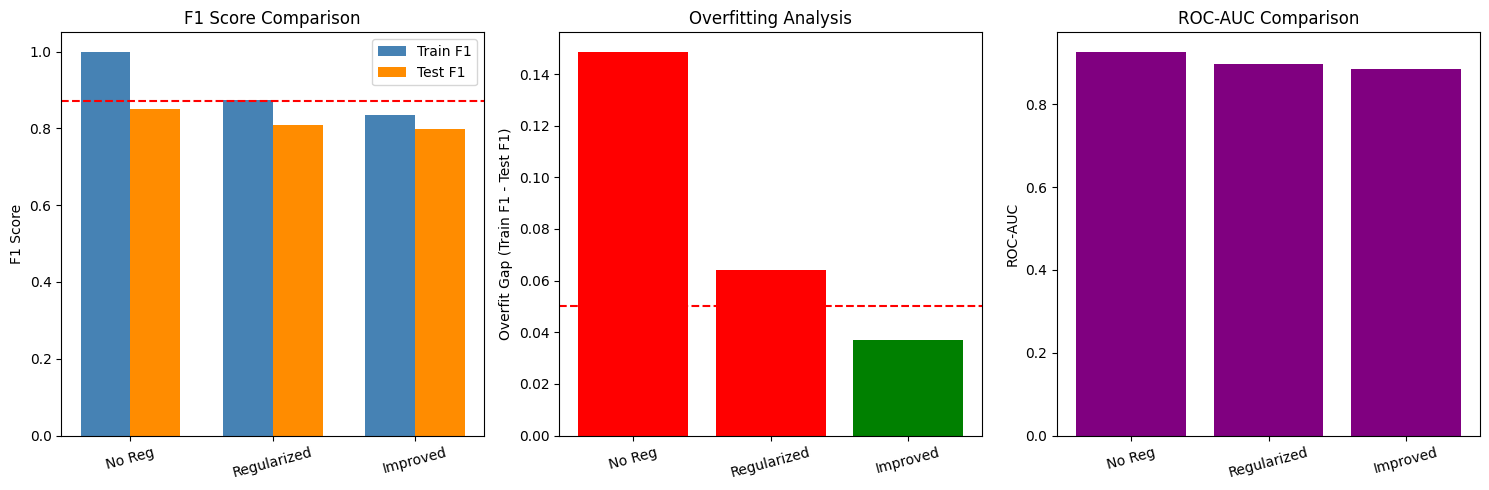

In [29]:
# Visual comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# F1 Score comparison
x = range(len(comparison_df))
width = 0.35
axes[0].bar([i - width/2 for i in x], comparison_df['Train F1'], width, label='Train F1', color='steelblue')
axes[0].bar([i + width/2 for i in x], comparison_df['Test F1'], width, label='Test F1', color='darkorange')
axes[0].set_xticks(x)
axes[0].set_xticklabels(['No Reg', 'Regularized', 'Improved'], rotation=15)
axes[0].set_ylabel('F1 Score')
axes[0].set_title('F1 Score Comparison')
axes[0].legend()
axes[0].axhline(y=0.87, color='red', linestyle='--', label='Target Min')

# Overfit gap
colors = ['red' if gap > 0.05 else 'green' for gap in comparison_df['Overfit Gap']]
axes[1].bar(x, comparison_df['Overfit Gap'], color=colors)
axes[1].set_xticks(x)
axes[1].set_xticklabels(['No Reg', 'Regularized', 'Improved'], rotation=15)
axes[1].set_ylabel('Overfit Gap (Train F1 - Test F1)')
axes[1].set_title('Overfitting Analysis')
axes[1].axhline(y=0.05, color='red', linestyle='--', label='Overfit Threshold')

# ROC-AUC comparison
axes[2].bar(x, comparison_df['ROC-AUC'], color='purple')
axes[2].set_xticks(x)
axes[2].set_xticklabels(['No Reg', 'Regularized', 'Improved'], rotation=15)
axes[2].set_ylabel('ROC-AUC')
axes[2].set_title('ROC-AUC Comparison')

plt.tight_layout()
plt.show()

---
## 11. Hyperparameter Tuning

Perform hyperparameter tuning on the best model from ablation study using RandomizedSearchCV for efficiency.

In [30]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import time

# Determine best base model for tuning
base_models = {
    'noreg': (gb_noreg, metrics_noreg, 'No Regularization'),
    'reg': (gb_reg, metrics_reg, 'Regularized'),
    'improved': (gb_improved, metrics_improved, 'Improved')
}

best_base_name = max(base_models.keys(), key=lambda k: base_models[k][1]['test_f1'])
best_base_model, best_base_metrics, best_base_label = base_models[best_base_name]

print(f"Best base model for tuning: Gradient Boosting ({best_base_label})")
print(f"Current Test F1: {best_base_metrics['test_f1']:.4f}")
print(f"Current Overfit Gap: {best_base_metrics['overfit_gap']:.4f}")

Best base model for tuning: Gradient Boosting (No Regularization)
Current Test F1: 0.8512
Current Overfit Gap: 0.1487


In [31]:
# Define hyperparameter search space for Gradient Boosting
param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.19),  # 0.01 to 0.20
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'max_leaf_nodes': randint(50, 200),
    'subsample': uniform(0.6, 0.4),  # 0.6 to 1.0
    'min_impurity_decrease': uniform(0, 0.01)
}

# Create base model for tuning
gb_tune = GradientBoostingClassifier(
    random_state=42
)

print("Hyperparameter Search Space:")
for param, dist in param_distributions.items():
    print(f"  {param}: {dist}")

Hyperparameter Search Space:
  n_estimators: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001D10EA0D550>
  max_depth: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001D10E9F2D50>
  learning_rate: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001D10EA0D6A0>
  min_samples_split: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001D10E9F3110>
  min_samples_leaf: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001D10ACA69E0>
  max_features: ['sqrt', 'log2', None]
  max_leaf_nodes: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001D10ACA6EA0>
  subsample: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001D10E9F3250>
  min_impurity_decrease: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001D10E9F34D0>


In [32]:
# Set experiment for hyperparameter tuning
mlflow.set_experiment(f"{EXPERIMENT_BASE_NAME}_tuned")

# Perform randomized search
print("\nStarting Hyperparameter Tuning (this may take several minutes)...")
print("="*60)

start_time = time.time()

random_search = RandomizedSearchCV(
    estimator=gb_tune,
    param_distributions=param_distributions,
    n_iter=30,  # Number of parameter combinations to try
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train_scaled, y_train, sample_weight=sample_weights_train)

tuning_time = time.time() - start_time
print(f"\nTuning completed in {tuning_time/60:.2f} minutes")
print(f"\nBest parameters found:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV F1 Score: {random_search.best_score_:.4f}")

2026/01/31 17:02:16 INFO mlflow.tracking.fluent: Experiment with name 'GradientBoosting_balanced_smote_tuned' does not exist. Creating a new experiment.



Starting Hyperparameter Tuning (this may take several minutes)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Tuning completed in 27.22 minutes

Best parameters found:
  learning_rate: 0.04775597949149276
  max_depth: 9
  max_features: None
  max_leaf_nodes: 130
  min_impurity_decrease: 0.0071134195274865
  min_samples_leaf: 3
  min_samples_split: 2
  n_estimators: 478
  subsample: 0.6296178606936361

Best CV F1 Score: 0.8453



Gradient Boosting (Tuned) Evaluation Results

Accuracy  - Train: 1.0000 | Test: 0.8646
F1 Score  - Train: 1.0000 | Test: 0.8579
Precision: 0.9028
Recall:    0.8173
ROC-AUC:   0.9347

Overfit Gap (Train F1 - Test F1): 0.1421
⚠️  WARNING: Model shows signs of overfitting!


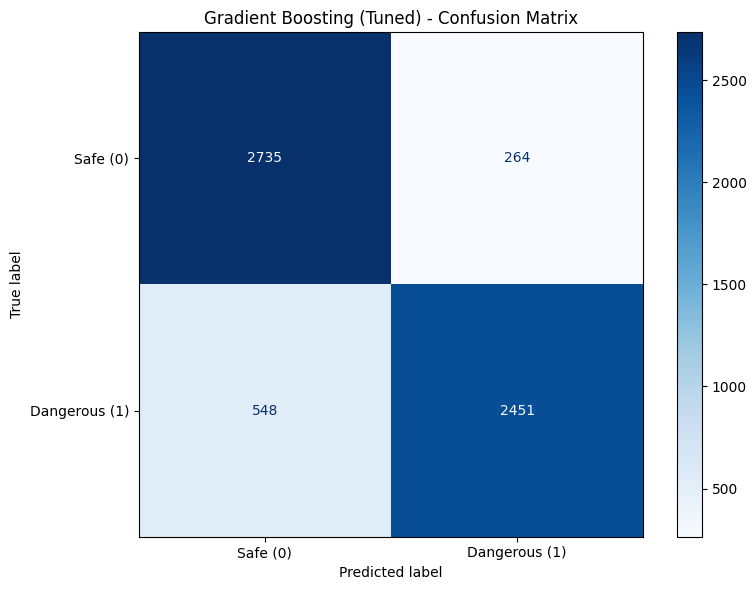

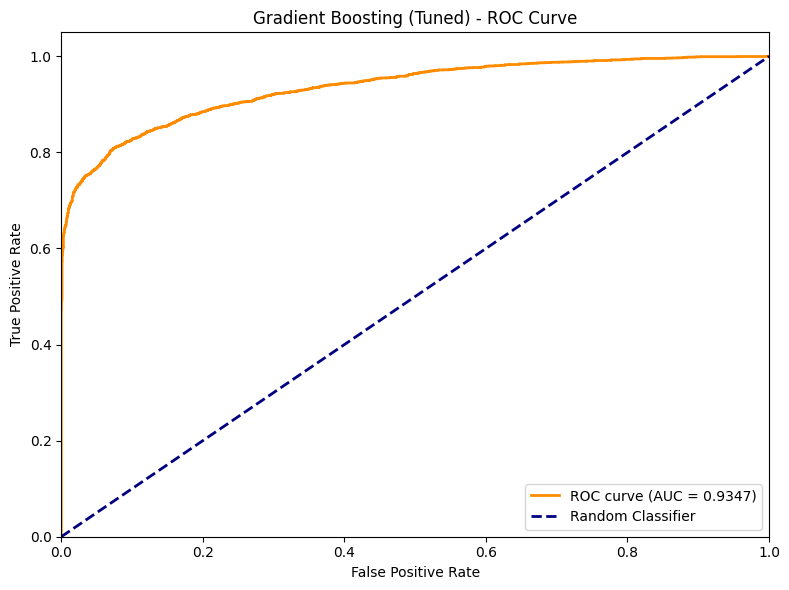

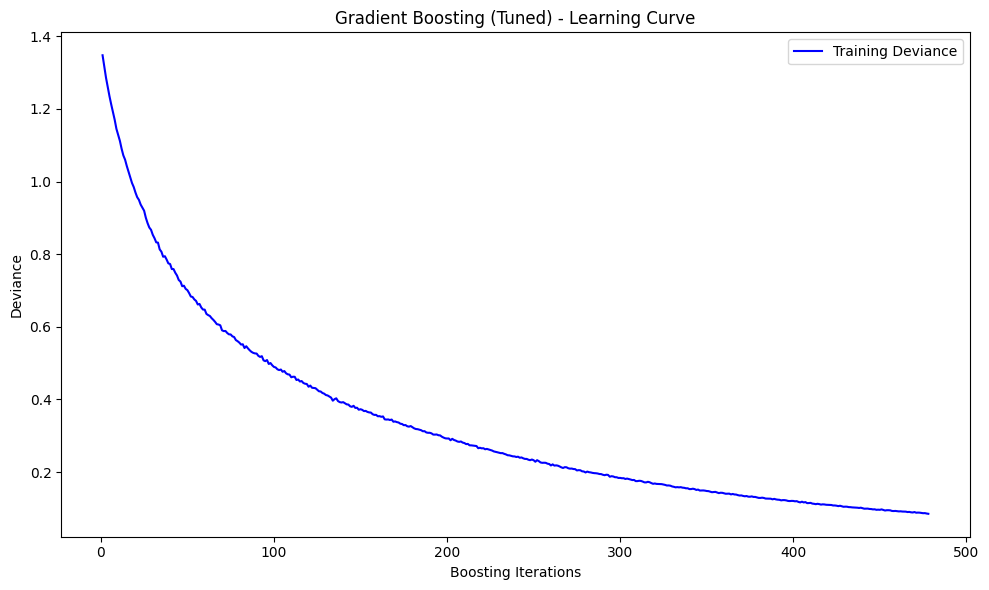

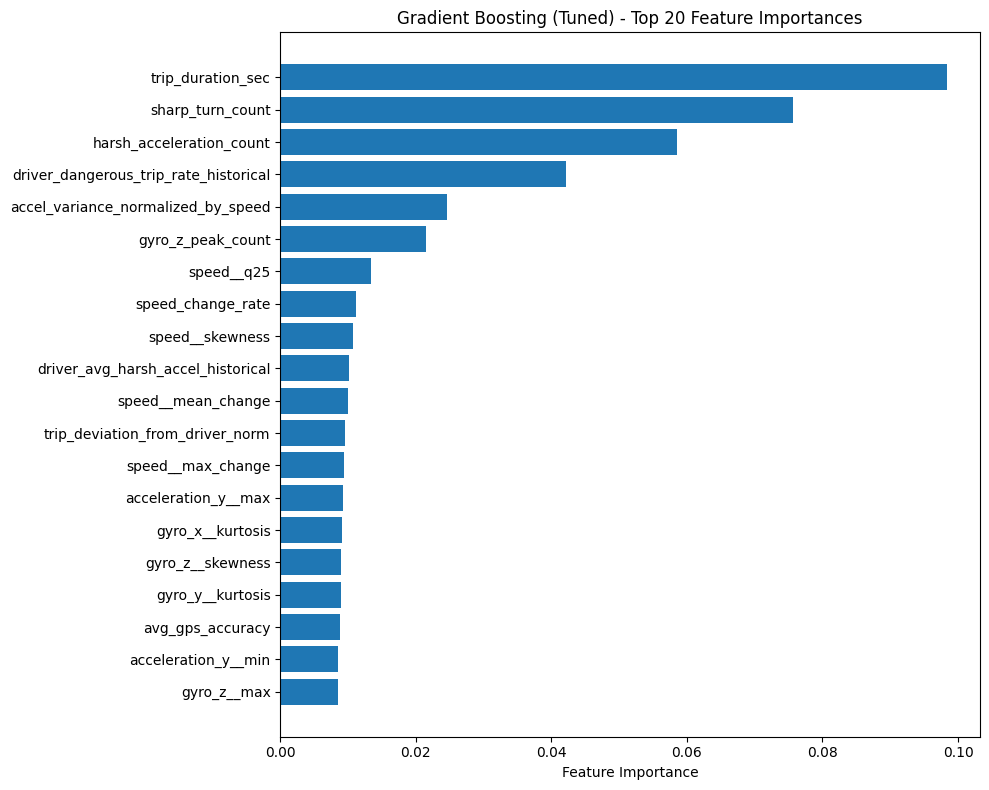

2026/01/31 17:29:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✅ Tuned model logged to MLflow with ID: 430c83db0a96405a8cc1af7eeaba6969
🏃 View run GradientBoosting_Tuned at: http://localhost:5000/#/experiments/16/runs/430c83db0a96405a8cc1af7eeaba6969
🧪 View experiment at: http://localhost:5000/#/experiments/16


In [33]:
# Evaluate tuned model
gb_tuned = random_search.best_estimator_

with mlflow.start_run(run_name="GradientBoosting_Tuned"):
    # Log best parameters
    mlflow.log_params(random_search.best_params_)
    mlflow.log_param("tuning_method", "RandomizedSearchCV")
    mlflow.log_param("n_iter", 30)
    mlflow.log_param("cv_folds", 5)
    mlflow.log_param("dataset", "balanced_smote")
    mlflow.log_param("tuning_time_minutes", round(tuning_time/60, 2))
    
    # Evaluate tuned model
    metrics_tuned, y_pred_tuned, y_proba_tuned = evaluate_model(
        gb_tuned, X_train_scaled, X_test_scaled, y_train, y_test, 
        model_name="Gradient Boosting (Tuned)"
    )
    
    # Log metrics
    mlflow.log_metrics({
        'train_accuracy': metrics_tuned['train_accuracy'],
        'test_accuracy': metrics_tuned['test_accuracy'],
        'train_f1': metrics_tuned['train_f1'],
        'test_f1': metrics_tuned['test_f1'],
        'precision': metrics_tuned['precision'],
        'recall': metrics_tuned['recall'],
        'roc_auc': metrics_tuned['roc_auc'],
        'overfit_gap': metrics_tuned['overfit_gap'],
        'cv_best_f1': random_search.best_score_
    })
    
    # Plot and log confusion matrix
    fig_cm = plot_confusion_matrix(y_test, y_pred_tuned, "Gradient Boosting (Tuned)")
    mlflow.log_figure(fig_cm, "confusion_matrix_tuned.png")
    plt.show()
    
    # Plot and log ROC curve
    fig_roc = plot_roc_curve(y_test, y_proba_tuned, "Gradient Boosting (Tuned)")
    mlflow.log_figure(fig_roc, "roc_curve_tuned.png")
    plt.show()
    
    # Plot and log learning curve
    fig_lc = plot_learning_curve(gb_tuned, "Gradient Boosting (Tuned)")
    mlflow.log_figure(fig_lc, "learning_curve_tuned.png")
    plt.show()
    
    # Plot and log feature importance
    fig_fi = plot_feature_importance(gb_tuned, X_train_scaled.columns.tolist(), top_n=20, 
                                     model_name="Gradient Boosting (Tuned)")
    mlflow.log_figure(fig_fi, "feature_importance_tuned.png")
    plt.show()
    
    # Log model
    signature = infer_signature(X_train_scaled, y_train)
    mlflow.sklearn.log_model(gb_tuned, "model", signature=signature)
    
    print(f"\n✅ Tuned model logged to MLflow with ID: {mlflow.active_run().info.run_id}")

In [34]:
# Compare tuned model with best base model
print("\n" + "="*70)
print("TUNING COMPARISON: Best Base Model vs Tuned Model")
print("="*70)

comparison_tuning = pd.DataFrame({
    'Model': [f'Gradient Boosting ({best_base_label})', 'Gradient Boosting (Tuned)'],
    'Train F1': [best_base_metrics['train_f1'], metrics_tuned['train_f1']],
    'Test F1': [best_base_metrics['test_f1'], metrics_tuned['test_f1']],
    'ROC-AUC': [best_base_metrics['roc_auc'], metrics_tuned['roc_auc']],
    'Overfit Gap': [best_base_metrics['overfit_gap'], metrics_tuned['overfit_gap']]
})

print(comparison_tuning.to_string(index=False))

# Calculate improvement
f1_improvement = metrics_tuned['test_f1'] - best_base_metrics['test_f1']
overfit_improvement = best_base_metrics['overfit_gap'] - metrics_tuned['overfit_gap']

print(f"\n📊 Improvement Summary:")
print(f"   F1 Score Change: {f1_improvement:+.4f} ({'✅ Improved' if f1_improvement > 0 else '❌ No improvement'})")
print(f"   Overfit Gap Change: {overfit_improvement:+.4f} ({'✅ Less overfitting' if overfit_improvement > 0 else '⚠️ More overfitting'})")

# Determine final best model
TUNING_IMPROVED = metrics_tuned['test_f1'] > best_base_metrics['test_f1']
if TUNING_IMPROVED:
    print(f"\n🏆 Tuned model is better! Will save tuned model.")
else:
    print(f"\n📌 Base model ({best_base_label}) is better or equal. Will save base model.")


TUNING COMPARISON: Best Base Model vs Tuned Model
                                Model  Train F1  Test F1  ROC-AUC  Overfit Gap
Gradient Boosting (No Regularization)  0.999917 0.851198 0.927846     0.148719
            Gradient Boosting (Tuned)  1.000000 0.857893 0.934699     0.142107

📊 Improvement Summary:
   F1 Score Change: +0.0067 (✅ Improved)
   Overfit Gap Change: +0.0066 (✅ Less overfitting)

🏆 Tuned model is better! Will save tuned model.


---
## 12. Save Best Model

In [35]:
import joblib
import os

# Create models directory
models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)

# Determine best model (including tuned)
models = {
    'noreg': (gb_noreg, metrics_noreg),
    'reg': (gb_reg, metrics_reg),
    'improved': (gb_improved, metrics_improved),
    'tuned': (gb_tuned, metrics_tuned)
}

best_model_name = max(models.keys(), key=lambda k: models[k][1]['test_f1'])
best_model, best_metrics = models[best_model_name]

# Save the best model
model_path = os.path.join(models_dir, 'gradientboosting_best_model.joblib')
joblib.dump(best_model, model_path)

# Save the scaler
scaler_path = os.path.join(models_dir, 'gradientboosting_scaler.joblib')
joblib.dump(scaler, scaler_path)

print(f"Best model saved: {model_path}")
print(f"Scaler saved: {scaler_path}")
print(f"\nBest Model: Gradient Boosting ({best_model_name})")
print(f"Test F1 Score: {best_metrics['test_f1']:.4f}")
print(f"Overfit Gap: {best_metrics['overfit_gap']:.4f}")

Best model saved: ../models\gradientboosting_best_model.joblib
Scaler saved: ../models\gradientboosting_scaler.joblib

Best Model: Gradient Boosting (tuned)
Test F1 Score: 0.8579
Overfit Gap: 0.1421


---
## Summary

This notebook trained Gradient Boosting models for dangerous driving detection with:

1. **No Regularization (Baseline)**: High complexity model to establish baseline and identify overfitting
2. **With Regularization**: Applied shrinkage, subsampling, and early stopping
3. **Improved Model**: Enhanced preprocessing and optimized hyperparameters for better F1 score

### Key Findings:
- Class imbalance handled using sample weights
- Stochastic gradient boosting (subsampling) helps prevent overfitting
- Early stopping prevents over-training
- All experiments tracked in MLflow for comparison

### Next Steps:
- Compare with other models (XGBoost, LightGBM, Random Forest)
- Run hyperparameter tuning if needed
- Deploy best model for production